# Data analysis of data science jobs listed on Indeed

In this notebook I will be exploring data about data science jobs listed on Indeed.  
The notebook is structured by the following questions:

* [What are the most common locations in the dataset?](#most_common_locations)
* [Where are the most job locations?](#heat_map)
* [What are the most common companies in the dataset?](#most_common_companies)
* [How does the distribution of salaries look like?](#salary_distribution)
* [Which companies list the highest salaries?](#highest_salaries)
* [What are the most common keywords in (English) descriptions?](#most_common_keywords)

## Data sources:

**data_science_jobs_2020-10-01.json:**

Scraped data from de.indeed.com. It consists of search results for the search phrase "data science". For each result I scraped the job title, company, location, salary and a short description. If you want to find out more about how I did that and see the code of the web scraper have a look at my repository on GitHub: https://github.com/felix-datascience/indeed_scraper

**DE.tab**

http://opengeodb.giswiki.org/wiki/OpenGeoDB

## Importing necessary libraries:

In [35]:
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# geospatial analysis
import folium
from folium import Marker
from folium.plugins import HeatMap

# nlp
from langdetect import detect
import spacy
from collections import Counter
from string import punctuation
import en_core_web_sm
import de_core_news_sm

#### Plotting settings

In [3]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

## Loading data:

In [4]:
jobs_path = './data/data_science_jobs_2020-10-01.json'
#cities_path = './data/postleitzahlen-deutschland/postleitzahlen-deutschland.shp'
#basemap_path = './data/xn--VG250_Bundeslndergrenzen-shp-inc/VG250_Bundesländergrenzen.shp'
coords_path = './data/DE.tab'

jobs_df = pd.read_json(jobs_path)
#cities_df = gpd.read_file(cities_path)
#basemap_df = gpd.read_file(basemap_path)
coords_df = pd.read_csv(coords_path, sep='\t', low_memory=False)

## Data preparation:

### jobs_df

#### Remove "\n"s

From the first 10 rows we can already see that there is a **unnecessary "\n"** at the beginning of each string in the **"company"** and **salary** column. We can also already see that most job ads don't contain information about the salary.

In [5]:
jobs_df.head(10)

,title,company,location,salary,description
0,Projektleiter Data Science / Marktforschung (w...,\ndm-drogerie markt,Karlsruhe,None,[Das Team Marktforschung im Ressort Produktman...
1,AI Data Scientist / Signal Processing (f/m/d),\nWOW Tech Group,Berlin,None,[You have solid practical and/or theoretical e...
2,Marketing Data Scientist (m/w/d),\nKarlsberg Service GmbH,Homburg,None,[Dieser Satz steht in seiner Kürze für einen i...
3,Research Scientist (f/m/d) - Visual Data Science,\nSiemens AG,München,None,"[In addition, you are responsible for the supe..."
4,Data Warehouse Engineer,\nOpel Vauxhall Finance,Rüsselsheim,None,"[Responsible for extracting , data, from vari..."
5,Director of Data Management (m/f/x),\nZAGENO Inc,Berlin,None,"[Drive KPIs for catalog , data, accuracy., Dr..."
6,Quantum Computing Algorithm,\nDLR - Deutsches Zentrum für Luft- und Raumfahrt,Köln,None,"[PhD in physics, computer , science, , mathema..."
7,DM.178.20b Scientific Research Assistant (f/m/d),\nCharité,Berlin,None,"[Solid basic experience in scientific , data, ..."
8,Data Scientist (m/w/d),\nskipsearch GmbH,Nürnberg,\n70.000 € pro Jahr,"[Was ist das für eine Stelle?*., Wir sind vera..."
9,Postdoctoral Fellow in Bioinformatics,\nDeutsches Krebsforschungszentrum,Heidelberg,None,"[You are interested in , data, , science, , s..."


Let us remove the "\n" from the "company" and "salary" column.

In [6]:
def remove_n(string):
    if type(string) == str:
        return string[1:]
    # return NoneType values without manipulation
    else:
        return string

jobs_df['company'] = jobs_df['company'].apply(remove_n)
jobs_df['salary'] = jobs_df['salary'].apply(remove_n)

jobs_df.head(10)

,title,company,location,salary,description
0,Projektleiter Data Science / Marktforschung (w...,dm-drogerie markt,Karlsruhe,None,[Das Team Marktforschung im Ressort Produktman...
1,AI Data Scientist / Signal Processing (f/m/d),WOW Tech Group,Berlin,None,[You have solid practical and/or theoretical e...
2,Marketing Data Scientist (m/w/d),Karlsberg Service GmbH,Homburg,None,[Dieser Satz steht in seiner Kürze für einen i...
3,Research Scientist (f/m/d) - Visual Data Science,Siemens AG,München,None,"[In addition, you are responsible for the supe..."
4,Data Warehouse Engineer,Opel Vauxhall Finance,Rüsselsheim,None,"[Responsible for extracting , data, from vari..."
5,Director of Data Management (m/f/x),ZAGENO Inc,Berlin,None,"[Drive KPIs for catalog , data, accuracy., Dr..."
6,Quantum Computing Algorithm,DLR - Deutsches Zentrum für Luft- und Raumfahrt,Köln,None,"[PhD in physics, computer , science, , mathema..."
7,DM.178.20b Scientific Research Assistant (f/m/d),Charité,Berlin,None,"[Solid basic experience in scientific , data, ..."
8,Data Scientist (m/w/d),skipsearch GmbH,Nürnberg,70.000 € pro Jahr,"[Was ist das für eine Stelle?*., Wir sind vera..."
9,Postdoctoral Fellow in Bioinformatics,Deutsches Krebsforschungszentrum,Heidelberg,None,"[You are interested in , data, , science, , s..."


#### Turn description list into string

The last row of the dataframe consists of a short job description. The disriptions are stored as lists and each element is a key word or sentence describing the job or company. Lists are uneasy to work with inside of pandas dataframes and also the seperation of the list elements does not add any value as you can see in this example:

In [7]:
jobs_df.loc[9]['description']

['You are interested in ',
 'data',
 ' ',
 'science',
 ', statistics, scientific computing, and cancer.',
 'You are excited by pushing ',
 'science',
 ' forward with your own ideas.']

It is easier to have the descriptions as single strings for better readability and better working with pandas.

In [8]:
# turn description list into string
def description_str(desc_list):
    return ''.join(desc_list)

jobs_df['description'] = jobs_df['description'].apply(description_str)

jobs_df.loc[9]['description']

'You are interested in data science, statistics, scientific computing, and cancer.You are excited by pushing science forward with your own ideas.'

That is a lot easier to read!

#### Removing duplicates

Some job ads are listed multiple times. I will remove all duplicates that have the same job title, company, location, salary and description. I think that it is best to do so as I don't think the number of same job ads represents the number of positions that a company tries to fill. It has rather something to do with Indeed's search algorithm and the way that the ads are generated. Let us remove all duplicates and leave only the first appearance:

In [9]:
jobs_df.duplicated().value_counts()

False    958
True     774
dtype: int64

In [10]:
jobs_df.drop_duplicates(inplace=True)

#### Create numerical columns from salary strings

Now if we have a look at the Salary column we can see that we are using strings. Using numerical values would be a lot easier to word with though. Let's add another column for that. The salaries are represented diffrerently though:

In [11]:
jobs_df['salary'].unique()[:10]

array([None, '70.000 € pro Jahr', '102.663 € - 133.465 € pro Jahr',
       '1.500 € pro Monat', '140.000 € - 180.000 € pro Jahr',
       '150.000 € - 200.000 € pro Jahr', '1.425 € pro Monat',
       '1.036 € - 1.160 € pro Monat', '110.000 € pro Jahr',
       '60.000 € - 80.000 € pro Jahr'], dtype=object)

* single values vs. range of values
* salary per hour ("pro Stunde"), day ("pro Tag"), month ("pro Monat") or year ("pro Jahr")

Let's calculate the annual income for each job (that supplies information about the salary). We assume a day has 8 work hours, a month 21.75 days (174 hours) and a year 261 days (2088 hours) of work. We will add two columns, one for single value salaries and starting values of ranges and another column for end values of ranges.

In [12]:
year_hours = 2088
year_days = 261
year_months = 12

def get_start_values(salary_str):
    if salary_str == None:
        return np.nan
    else:
        start_str = salary_str.split(' € ')[0].replace('.', '')
        start_num = pd.to_numeric(start_str)
        if 'Stunde' in salary_str:
            return start_num * year_hours
        elif 'Tag' in salary_str:
            return start_num * year_days
        elif 'Monat' in salary_str:
            return start_num * year_months
        elif 'Jahr' in salary_str:
            return start_num
    
def get_end_values(salary_str):
    if salary_str == None:
        return np.nan
    elif not '-' in salary_str:
        return np.nan
    else:
        end_str = salary_str.split(' € ')[1].replace('- ', '').replace('.', '')
        end_num = pd.to_numeric(end_str)
        if 'Stunde' in salary_str:
            return end_num * year_hours
        elif 'Tag' in salary_str:
            return end_num * year_days
        elif 'Monat' in salary_str:
            return end_num * year_months
        elif 'Jahr' in salary_str:
            return end_num

# add two new columns: hourly_wage_from, hourly_wage_to
jobs_df['annual_income_from'] = jobs_df['salary'].apply(get_start_values)
jobs_df['annual_income_to'] = jobs_df['salary'].apply(get_end_values)

# round values to 2 decimals
jobs_df = jobs_df.round({'hourly_wage_from':2, 'hourly_wage_to':2})

# print first five rows with salary data
jobs_df.dropna(subset=['salary']).head(5)

,title,company,location,salary,description,annual_income_from,annual_income_to
8,Data Scientist (m/w/d),skipsearch GmbH,Nürnberg,70.000 € pro Jahr,Was ist das für eine Stelle?*.Wir sind verantw...,70000.0,NaN
11,IT SPECIALIST (INFOSEC),US Department of the Air Force,Ramstein-Miesenbach,102.663 € - 133.465 € pro Jahr,"Comprehensive knowledge of national, defense a...",102663.0,133465.0
61,Internship (w/m/x) - Elevator Ventures,Raiffeisen Capital Management,Deutschland,1.500 € pro Monat,Currently ongoing studies at a university or c...,18000.0,NaN
213,Global Medical Affairs – CNS/Psychiatry,Barrington James,Deutschland,140.000 € - 180.000 € pro Jahr,Ability to interpret scientific and clinical t...,140000.0,180000.0
214,Global Medical Affairs Manager – CNS,Barrington James,Deutschland,150.000 € - 200.000 € pro Jahr,Ability to interpret scientific and clinical t...,150000.0,200000.0


### coords_df

This dataframe contains spatial data of more than 60000 German cities:

In [13]:
coords_df.head()

,#loc_id,ags,ascii,name,lat,lon,amt,plz,vorwahl,einwohner,flaeche,kz,typ,level,of,invalid
0,105,D,DEUTSCHLAND,Bundesrepublik Deutschland,51.16766,10.42498,NaN,NaN,NaN,82175684.0,357104.0,D,NaN,2.0,104.0,NaN
1,80076,16076087,KLEINWOLSCHENDORF,Kleinwolschendorf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,26599.0,0.0
2,80085,16076087,PAHREN,Pahren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ortsteil,8.0,26599.0,0.0
3,80070,16076087,DOERTENDORF,Dörtendorf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ortsteil,8.0,25089.0,0.0
4,80082,16076087,MEHLA,Mehla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ortsteil,8.0,25089.0,0.0


#### Dropping unnecessary columns and rows

We are going to use this dataframe to look for coordinates for each job location later. The only columns we need for that are the "name", "lat" and "lon" column so we drop avery other column. We are also dropping every row that does not provide a value in each of these columns.

In [14]:
# drop unnecessary columns
coords_df = coords_df[['name', 'lat', 'lon']]

# drop rows with any NaN
coords_df.dropna(inplace=True)

# print cleaned data
coords_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60981 entries, 0 to 61124
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    60981 non-null  object 
 1   lat     60981 non-null  float64
 2   lon     60981 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.9+ MB


## Analysis:

<a id='most_common_locations'></a>
### What are the most common locations in the dataset?

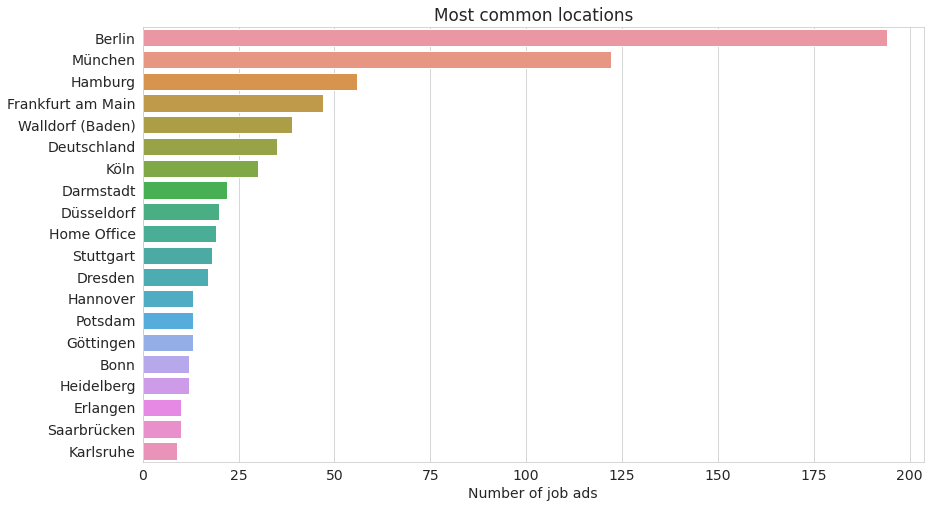

In [53]:
# 20 most common cities
most_common_locs = jobs_df['location'].value_counts()[:20]

plt.figure(figsize=(14,8))

plt.title('Most common locations')

most_common_locs_fig = sns.barplot(
    x=most_common_locs.values,
    y=most_common_locs.index.values
)

most_common_locs_fig.set_xlabel('Number of job ads')

plt.show()

When it comes to the amount of job ads per location Berlin definitely comes first. Munich comes second with roughly two thirds of Berlin. Home Office made it into the list as well.

<a id='heat_map'></a>
### Where are the most job locations?

#### Finding coordinates for each job location

To do a geospatial analysis we first need to connect the data from jobs_df to coords_df. We will create two new columns for the latitude and longitude and look for each job location name in the coords_df dataframe. *This might take up to a minute.*

In [22]:
# find lat for each location name
def get_lat(row):
    if row['location'].lower() in coords_df['name'].str.lower().values:
        # use first appearance of location name in case there is more than one
        return coords_df[coords_df['name'].str.lower() == row['location'].lower()]['lat'].iloc[0]        

# find lon for each location name
def get_lon(row):
    if row['location'].lower() in coords_df['name'].str.lower().values:
        # use first appearance of location name in case there is more than one
        return coords_df[coords_df['name'].str.lower() == row['location'].lower()]['lon'].iloc[0]
    
    
# add lat and lon columns to jobs_df
jobs_df['lat'] = jobs_df.apply(get_lat, axis=1)
jobs_df['lon'] = jobs_df.apply(get_lon, axis=1)

jobs_df.head()

,title,company,location,salary,description,annual_income_from,annual_income_to,lat,lon
0,Projektleiter Data Science / Marktforschung (w...,dm-drogerie markt,Karlsruhe,None,Das Team Marktforschung im Ressort Produktmana...,NaN,NaN,49.00470,8.38583
1,AI Data Scientist / Signal Processing (f/m/d),WOW Tech Group,Berlin,None,You have solid practical and/or theoretical ex...,NaN,NaN,52.52464,13.40514
2,Marketing Data Scientist (m/w/d),Karlsberg Service GmbH,Homburg,None,Dieser Satz steht in seiner Kürze für einen in...,NaN,NaN,NaN,NaN
3,Research Scientist (f/m/d) - Visual Data Science,Siemens AG,München,None,"In addition, you are responsible for the super...",NaN,NaN,48.13740,11.57550
4,Data Warehouse Engineer,Opel Vauxhall Finance,Rüsselsheim,None,Responsible for extracting data from various s...,NaN,NaN,49.99250,8.42500


Lets see which locations we couldn't find coordinates for:

In [23]:
jobs_df[jobs_df['lat'].isna()]['location'].value_counts()

Walldorf                 39
Deutschland              35
Home Office              19
Berlin-Kreuzberg         16
Berlin-Friedrichshain     4
Nehren                    2
Marburg an der Lahn       2
Wolfsburg, Stadt          2
Berlin-Neukölln           2
Berlin-Schöneberg         1
Rust                      1
Oberhaching               1
Neu Isenburg              1
Homburg                   1
Oberpfaffenhofen          1
Ilmenau                   1
Sachsen-Anhalt            1
Berlin-Adlershof          1
Name: location, dtype: int64

There are two types of locations we could not find information for:

Locations which do not appear in the coords dataset because they are not cities. We won't be able to add coordinates to job ads with these location values:

* "Deutschland" (Germany) - obviously not a citiy
* "Home Office" - not a city either
* "Sachsen-Anhalt" (German state)

Locations which use different notations than in the coords data set. Mostly different suffixes (e.g. "Berlin-Neukölln" instead of just "Berlin" or "Walldorf" instead of "Walldorf (Baden)" are used:

* different districts of Berlin -> "Berlin"
* "Wolfsburg, Stadt" -> "Wolfsburg"
* "Marburg an der Lahn" -> "Marburg / Lahn"
* "Homburg"-> "Homburg (Saar)"
* "Walldorf" -> "Walldorf (Baden)"
* "Nehren" -> "Nehren (Württemberg)"
* "Oberhaching" -> "Oberhaching bei München"
* "Rust" -> "Rust (Baden)"
* "Ilmenau" -> "Ilmenau, Thüringen"
* "Oberpfaffenhofen" -> "Oberpfaffenhofen Oberbayern"
* "Neu Isenburg" -> "Neu-Isenburg"

Let's write a function to change the location names of the second type and find coordinates for them:

In [24]:
# dict for invalid city names except Berlin districts
invalid_cities_dict = {
    'Wolfsburg, Stadt' : 'Wolfsburg',
    'Marburg an der Lahn' : 'Marburg / Lahn',
    'Homburg': 'Homburg (Saar)',
    'Walldorf' : 'Walldorf (Baden)',
    'Nehren' : 'Nehren (Württemberg)',
    'Oberhaching' : 'Oberhaching bei München',
    'Rust' : 'Rust (Baden)',
    'Ilmenau' : 'Ilmenau, Thüringen',
    'Oberpfaffenhofen' : 'Oberpfaffenhofen, Oberbayern',
    'Neu Isenburg' : 'Neu-Isenburg'
}

def change_invalid_city_names(row):
    # don't change when coordinates already found
    if pd.notna(row['lon']):
        return row['location']
    # change Berlin district names to just 'Berlin'
    elif 'Berlin' in row['location']:
        return 'Berlin'
    # change city names that are in the dict above
    elif row['location'] in invalid_cities_dict.keys():
        return invalid_cities_dict[row['location']]
    # don't change in any other case (e.g. 'Homeoffice')
    else:
        return row['location']

jobs_df['location'] = jobs_df.apply(change_invalid_city_names, axis=1)

# add missing coordinates
def get_missing_lat(row):
    if pd.notna(row['lat']):
        return row['lat']
    else:
        return get_lat(row)
    
def get_missing_lon(row):
    if pd.notna(row['lon']):
        return row['lon']
    else:
        return get_lon(row)

jobs_df['lat'] = jobs_df.apply(get_missing_lat, axis=1)
jobs_df['lon'] = jobs_df.apply(get_missing_lon, axis=1)

#### Visualizing job locations

We are now going to create a heatmap to visualize the job locations. For that we are using the heatmap plugin from leaflet. The heatmap treats multiple points with the exact same location as only one point which is impractical for our case as we have for example more than 150 jobs in Berlin. To counteract this bias we will add randomness to the "lat" and "lon" data so the points are close to each other but not at the exact same location.

In [40]:
base_map = folium.Map(location=[51.5,10], tiles='cartodbpositron', zoom_start=5.5)

heat_map_data = jobs_df[['title', 'location', 'lat', 'lon']].dropna()

# create noise matrix
noise = np.random.normal(0, 0.1, [len(heat_map_data), 2])

# add noise to heat_map_data
heat_map_data[['lat', 'lon']] = heat_map_data[['lat', 'lon']] + noise

# add heat map layer
HeatMap(
    data=heat_map_data[['lat', 'lon']],
    radius=20,
    blur=18,
    max_val=0.01
).add_to(base_map)


# job count for 20 locations with highest count
job_city_count = jobs_df.value_counts(['location', 'lat', 'lon']).sort_values(ascending=False)[:20]

# add marker layer with job counts
for loc, count in job_city_count.iteritems():
    Marker(
        location=[loc[1], loc[2]],
        #radius=1,
        tooltip=f"{loc[0]}: {count} jobs"
    ).add_to(base_map)

base_map

<a id='most_common_companies'></a>
### What are the most common companies in the dataset?

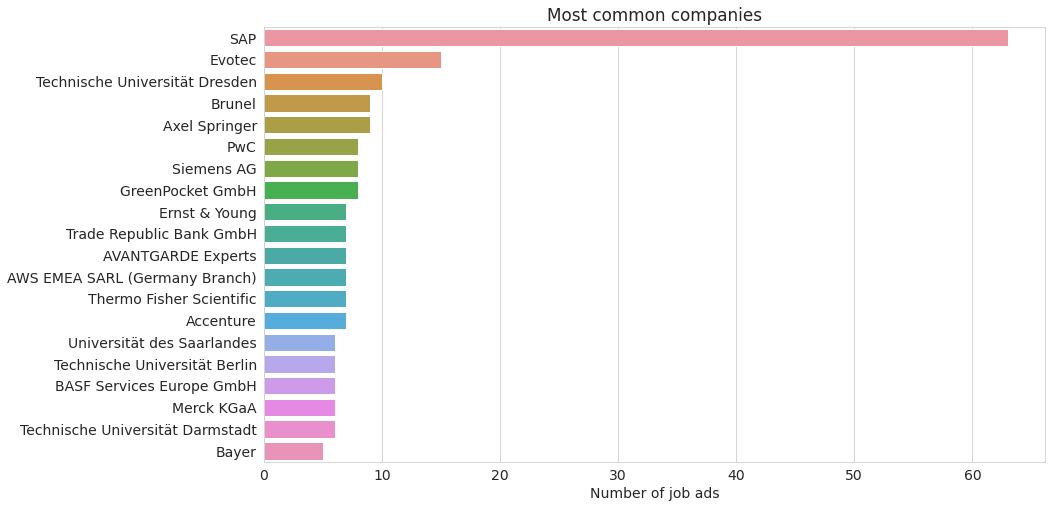

In [54]:
# 20 most common companies
most_common_companies = jobs_df['company'].value_counts()[:20]

plt.figure(figsize=(14,8))

plt.title('Most common companies')

most_common_companies_fig = sns.barplot(
    x=most_common_companies.values,
    y=most_common_companies.index.values
)

most_common_companies_fig.set_xlabel('Number of job ads')

plt.show()

At the time the data was collected SAP was far ahead with the number of job ads. The rest of the companies in the list are almost on the same level, at relatively to SAP.

<a id='salary_distribution'></a>
### How does the distribution of salaries look like?

Let us now have a look at the distribution of salaries. The following figure will show the distribution of all the annual incomes that were given as a single value and the lower boundaries of the ones given as a range in blue. The upper boundaries of incomes given as ranges are plotted in orange

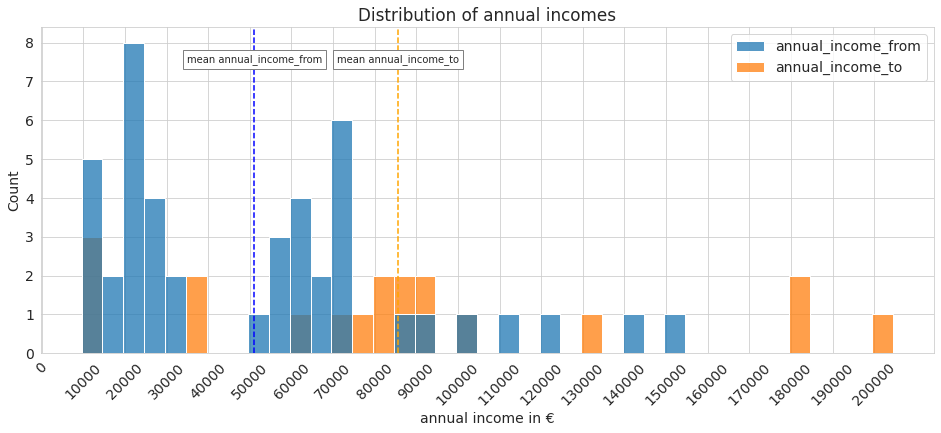

In [55]:
plt.figure(figsize=(16,6))

plt.title('Distribution of annual incomes')

wages_dist = sns.histplot(jobs_df[['annual_income_from', 'annual_income_to']], binwidth=5000)

ticks_x = [x for x in range(0,200001,10000)]

wages_dist.set_xticks(ticks_x)
wages_dist.set_xticklabels(ticks_x, rotation=45)

wages_dist.set_xlabel('annual income in €')

# vertical lines for mean values
plt.axvline(jobs_df['annual_income_from'].mean(), color='blue', linestyle='--', label='mean hourly_wages_from')
plt.axvline(jobs_df['annual_income_to'].mean(), color='orange', linestyle='--', label='mean hourly_wages_to',)

# annotate vertical lines
plt.text(jobs_df['annual_income_from'].mean(),7.5,'mean annual_income_from', ha='center', \
         fontsize=10, bbox=dict(facecolor='w', edgecolor='grey'))
plt.text(jobs_df['annual_income_to'].mean(),7.5,'mean annual_income_to', ha='center',  \
         fontsize=10, bbox=dict(facecolor='w', edgecolor='grey'))

plt.show()

The mean annual income generated from the upper boundaries is higher than the mean income generated from single values and lower boundaries, which makes sense.  
You can also see two very distinct peaks at around 20,000€ and 60,000€ / 70,000€.

Let's have a look at the job titles in each of these peaks.

First we will have look at the jobs that are under minimum wage (We assume all jobs to be full time which makes for a minimum wage annal income of around 19,500€). These should be internships and dual courses of study.

In [58]:
min_income = 9.35 * 8 * 261

jobs_df[jobs_df['annual_income_from'] < min_income]['title']

61                 Internship (w/m/x) - Elevator Ventures
263            Praktikum / Internship Market Intelligence
315     Student:in dualer Studiengänge – Bachelor of S...
353     Student:in dualer Studiengänge – Bachelor of S...
1170                JavaScript Full Stack Working Student
1365    Duales Studium Cyber Security (Bachelor of Sci...
1531                         Senior Game Designer (f/m/d)
Name: title, dtype: object

As suspected most of these job titles indicate the ad is for an internship or a dual studies course. Only two are not, it could be that they are part time jobs and thus the annual income is under our calculated minimum wage annual income.

Now we will take a look at the jobs that are still in the first peak, but higher or same as minimum wage:

In [59]:
jobs_df[(jobs_df['annual_income_from'] >= min_income) & (jobs_df['annual_income_from'] < 40000)]['title']

459     Academic research assistant (m/f/x) The Chair ...
485     Academic research assistant (m/f/x) The Chair ...
489     Academic research assistant (m/f/x) The Chair ...
643     2 postions - Research Assistant - salary grade...
644     Research Assistant (PostDoc) - salary grade E ...
648     Research Assistant - salary grade E 13 TV-L Be...
725     Supervisory Program Specialist (CYS Services) ...
793                         Project administrator (m/f/x)
831                           Project coordinator (m/f/x)
1048    Project coordinator (m/f/x) for the European U...
1156    Academic research assistant (m/f/x) The Depart...
1202                                       Data Scientist
1205    Project administrator (m/f/x) for the European...
1220                         CYS Assistant Director NF-03
Name: title, dtype: object

Most of these job ads are for research assistants.

Finally let's look at the second peak:

In [60]:
jobs_df[(jobs_df['annual_income_from'] >= 40000) & (jobs_df['annual_income_from'] < 80000)]['title']

8                                Data Scientist (m/w/d)
373                  Machine learning scientist (m/w/d)
406                             (Junior) Data Scientist
569                                Maintenance Engineer
660                           Sustainability Consultant
924                                Salesforce Developer
995                             Data Science Consultant
1036                            (Senior) Data Scientist
1356                       Full Stack Developer (m/w/d)
1378                                Electrical Engineer
1475           IT-Berater (M/F/D) - ETL/DWH - Frankfurt
1584                               Senior Data Engineer
1633                   Consultant Digitalisierung (mwd)
1649                      Senior Technical Lead (f/m/d)
1671    Accounting in Insurance (SAP) Senior Consultant
1705          (Senior) IT Berater Pharma / Chemie (mwd)
Name: title, dtype: object

We can see a few 'Senior's in these job titles, which explains why they higher, but we can also see job titles that don't immediately idicate higher / leading job positions. We are not going into detail here but it would be possible to find out more by looking at the other features like the description and company.

<a id='highest_salaries'></a>
### Which companies list the highest salaries?

We can not really expect to find out which companies offer the highest salaries to their data scientists as most job ads don't supply information about the salary. But anyway we can have a look at the data and see which companies list the highest salaries:

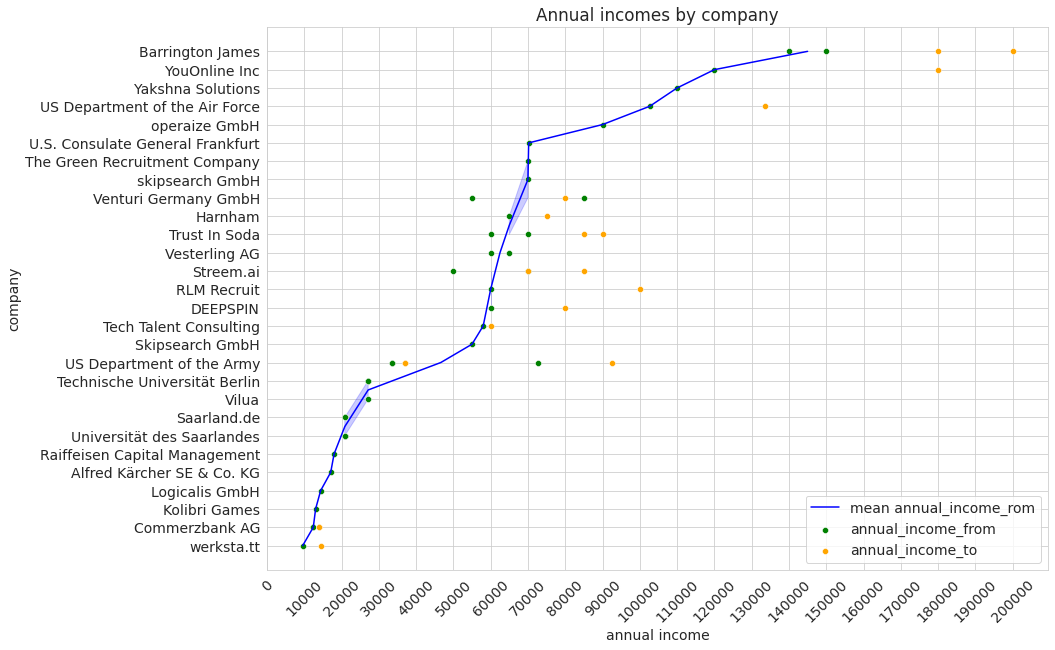

In [21]:
# subset containing only rows with salary not None, sorted by company
salaries = jobs_df.dropna(subset=['salary']).sort_values('company')

# mean values for hourly_wage_from and hourly_wage_to grouped by company
mean_per_comp = salaries.groupby('company').mean()
mean_per_comp = mean_per_comp.sort_values('annual_income_from', ascending=False)

plt.figure(figsize=(14,10))

plt.title('Annual incomes by company')

company_salary_from_mean = sns.lineplot(
    data=mean_per_comp,
    x='annual_income_from',
    y='company',
    color='b',
    label='mean annual_income_rom'
)

company_salary_from = sns.scatterplot(
    data=salaries,
    x='annual_income_from',
    y='company',
    color='g',
    label='annual_income_from'
)

company_salary_to = sns.scatterplot(
    data=salaries,
    x='annual_income_to',
    y='company',
    color='orange',
    label='annual_income_to'
)

ticks_x = [x for x in range(0,200001,10000)]

company_salary_from_mean.set_xticks(ticks_x)
company_salary_from_mean.set_xticklabels(ticks_x, rotation=45)

company_salary_from_mean.set_xlabel('annual income')

plt.legend(loc='lower right')

plt.show()

This figure does not show which companies pay the highest salaries. Only some job ads give information about the salary and for some companies only put their salary in job ads for dual study programs which makes these values not representative for the company. So the figure only tells us about the salaries listed on indeed.

### In which languages are the descriptions written?

In [26]:
# add new column for description language
jobs_df['desc_lang'] = jobs_df['description'].apply(detect)

jobs_df['desc_lang'].value_counts()

en    692
de    262
fr      2
nl      1
it      1
Name: desc_lang, dtype: int64

Most descriptions are written in English and German but there are also a few other job advertisements that are written in French, Italian and Dutch.

<a id='most_common_keywords'></a>
### What are the most common keywords in English descriptions?

The majority of descriptions are English so let's focus on them. Let's find out if there are any keywords in the descriptions that are used a lot. For that we are going to use spacy. We first need to import the Eglish spacy models.

In [27]:
nlp_en = en_core_web_sm.load()

Now we will concat all of the English description texts to one string that we will later search for keywords:

In [28]:
# all English descriptions concatenated to one string
desc_texts_en = jobs_df[jobs_df['desc_lang'] == 'en']['description'].str.cat(sep=' ')

We write a function to find all nouns and adjectives in the descriptions and store them in a list that is returned:

In [29]:
def get_keywords_en(text):
    keywords = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN']
    doc = nlp_en(text.lower())
    for token in doc:
        if(token.text in nlp_en.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            keywords.append(token.text)               
    return keywords

Next we use the function on the concatenated english description texts. We then extract the most common words and plot them in a bar chart:

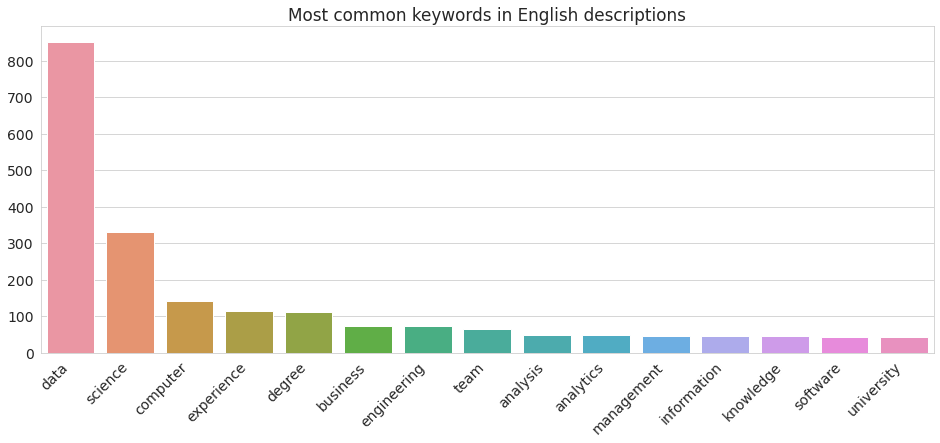

In [30]:
# all keywords
keywords_en = get_keywords_en(desc_texts_en)

# 10 most common keywords
most_common_en = {w:c for w,c in Counter(keywords_en).most_common(15)}

plt.figure(figsize=(16,6))

plt.title('Most common keywords in English descriptions')

most_common_keywords_fig = sns.barplot(
    x=list(most_common_en.keys()),
    y=list(most_common_en.values())
)

ticks_x = most_common_keywords_fig.get_xticklabels()

most_common_keywords_fig.set_xticklabels(ticks_x, rotation=45, ha='right')

plt.show()

The keyword **"data"** comes on top with a count of more than 800 which makes sence as we were searching for _"data science"_ jobs. Next comes **"science"** with a count of over 300. These two propably come together most of the time. We were not looking for the most common keyphrases though so we can only see the number of occurence of single keywords here. The keywords **"experience"** and **"degree"** come forth and fifth with a count of a little over 100 for both. This might show that a good proportion of companies are looking for data scientists that have a degree and / or experience in the field.